## Análisis Exploratorio de Datos (EDA)
---
La data historica descarga de la pagina oficial de la Bolsa de valores de Lima es del 31-10-24 al 31-10-25.

[Link Bolsa de Valores de Lima](https://www.bvl.com.pe/emisores/listado-emisores)

La Empresas analizadas son:

- Alicorp S.A.A  (productor de alimentos)
- Credicorp L.T.D  (holding financiero, controla BCP, AFP integra, Pacifico Vida)
- Ferreycorp S.A.A  (Distribuidora de Caterpillar - Maquinaria Pesada)
- Southern Cooper Corporation  (Minera - Produce cobre)

---

Calculo de Rendimientos (W) -  Manualmente

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('DATA_UNIFICADA.csv')

# calcular rendimientos : (X_t - X_t-1) / X_t-1
rendimientos = df.copy()
rendimientos.set_index('Fecha', inplace=True)

for col in rendimientos.columns:
    rendimientos[col] = (rendimientos[col] - rendimientos[col].shift(1)) / rendimientos[col].shift(1)

# eliminar primera fila (NaN porque no tiene dia anterior)
rendimientos = rendimientos.dropna()

rendimientos.head()

,ALICORP,CREDICORP,FERREYCORP,SOUTHERN
Fecha,,,,
2024-11-04,-0.015152,-0.016996,-0.006623,-0.024412
2024-11-05,0.000000,-0.013279,-0.010000,0.020091
2024-11-06,-0.004615,-0.001373,0.010101,-0.012534
2024-11-07,0.043277,0.010451,0.000000,-0.002720
2024-11-08,-0.010370,-0.004682,0.000000,0.000000


Calculo de Rendimientos (W) - Librerias

             ALICORP  CREDICORP  FERREYCORP  SOUTHERN
Fecha                                                
2024-11-04 -0.015152  -0.016996   -0.006623 -0.024412
2024-11-05  0.000000  -0.013279   -0.010000  0.020091
2024-11-06 -0.004615  -0.001373    0.010101 -0.012534
2024-11-07  0.043277   0.010451    0.000000 -0.002720
2024-11-08 -0.010370  -0.004682    0.000000  0.000000
2024-11-11  0.005988   0.011814    0.000000 -0.026364
2024-11-12 -0.013393   0.005135    0.000000 -0.021475
2024-11-13 -0.004525   0.015004   -0.006667 -0.023855
2024-11-14  0.000000  -0.000371   -0.003356 -0.012708
2024-11-15  0.000000  -0.006466    0.003367 -0.007921
2024-11-18  0.006061   0.018938    0.000000 -0.009980
2024-11-19 -0.006024   0.013141    0.003356  0.022681
2024-11-20 -0.009091  -0.003152   -0.010033  0.021981
2024-11-21  0.012232  -0.004666    0.010135 -0.000772
2024-11-22  0.004532   0.032813   -0.006689 -0.025097

Dimensión: (250, 4)


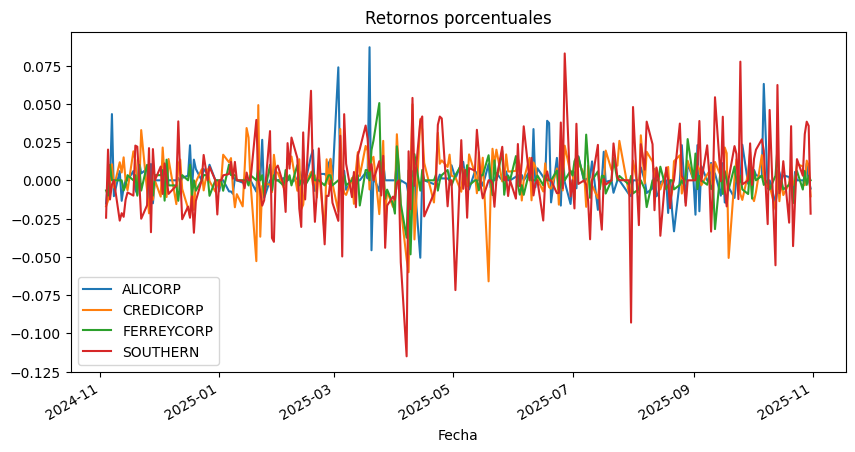

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. CARGA
df = pd.read_csv("DATA_UNIFICADA.csv")

# 2. FECHA COMO ÍNDICE
df["Fecha"] = pd.to_datetime(df["Fecha"], errors="coerce")
df = df.set_index("Fecha")

# 3. CONVERSIÓN NUMÉRICA
df = df.apply(pd.to_numeric, errors="coerce")

# 4. VARIACIÓN PORCENTUAL (SIN FILL)
W = df.pct_change(fill_method=None)

# 5. LIMPIEZA CORRECTA
# Eliminamos SOLO filas completamente vacías
W = W.dropna(how="all")

# 6. RESULTADO
print(W.head(15))
print("\nDimensión:", W.shape)

# 7. (OPCIONAL) GRÁFICO
W.plot(figsize=(10, 5))
plt.title("Retornos porcentuales")
plt.show()

Matriz de covarianza - Manualmente

In [30]:
import pandas as pd
import numpy as np

# convertir a matriz numpy
R = rendimientos.values
T = len(R)  # numero de dias de datos

mean = np.mean(R, axis=0)  # promedio por activo

# matriz de covarianza manual 
cov = (R - mean).T @ (R - mean) / (T - 1)

# convertir a dataframe con nombres de columnas y filas
cov_df = pd.DataFrame(cov, 
        index=['ALICORP', 'CREDICORP', 'FERREYCORP', 'SOUTHERN'],
        columns=['ALICORP', 'CREDICORP', 'FERREYCORP', 'SOUTHERN'])

# impresion de la matriz de covarianza
cov_df

,ALICORP,CREDICORP,FERREYCORP,SOUTHERN
ALICORP,0.000175,-0.000010,0.000001,-0.000012
CREDICORP,-0.000010,0.000252,0.000001,0.000111
FERREYCORP,0.000001,0.000001,0.000086,0.000026
SOUTHERN,-0.000012,0.000111,0.000026,0.000612


Matriz de Covarianza - Librerias

In [37]:
Q = W.cov()
print(Q)

             ALICORP  CREDICORP  FERREYCORP  SOUTHERN
ALICORP     0.000175  -0.000010    0.000001 -0.000012
CREDICORP  -0.000010   0.000252    0.000001  0.000111
FERREYCORP  0.000001   0.000001    0.000086  0.000026
SOUTHERN   -0.000012   0.000111    0.000026  0.000612


Descomposicion Choleski - Manualmente

In [39]:
import numpy as np
import pandas as pd


# hacemos una copia, con lo cual trabajaremos
cov = cov_df.to_numpy(copy=True)

# comprobaciones de simetría y autovalores

# simetria numerica
is_symmetric = np.allclose(cov, cov.T, atol=1e-12, rtol=1e-12)

# autovalores (para matrices simetricas usa eigvalsh)
eigvals = np.linalg.eigvalsh(cov)

# tolerancia numerica dependiente de la escala de la matriz
scale = max(1.0, np.linalg.norm(cov, ord=2))
tol = 1e-12 * scale

# es semidefinida positiva y simetrica(PSD) si todos los autovalores >= -tol
is_psd = np.all(eigvals >= -tol)

print("######   Comprobacion de la matriz Cov  para descomposicion ######")
print("La matriz Cov es simetrica:", is_symmetric)
print("Los autovalores son:", eigvals)
print("La matriz Cov es semidefinida positiva (numéricamente):", is_psd)

# descomposicion Cholesky
#   - Si es SPD (lambda_min > tol), Cholesky directo
#   - Si no, añadimos el jitter mínimo necesario para volverla SPD
lam_min = eigvals.min()
n = cov.shape[0]

def cholesky_with_min_jitter(A, lam_min, tol, safety=1e-12):
    """
    Intenta Cholesky directo. Si falla o A no es SPD,
    añade jitter = max(0, -lam_min) + safety * tr(A)/n y reintenta.
    """
    try:
        L = np.linalg.cholesky(A)
        jitter_used = 0.0
        return L, jitter_used
    except np.linalg.LinAlgError:
        pass

    # jitter minimo para empujar el menor autovalor por encima de 0
    jitter = max(0.0, -lam_min) + safety * (np.trace(A)/A.shape[0] if A.shape[0] > 0 else 1.0)
    A_j = A + jitter * np.eye(A.shape[0])
    L = np.linalg.cholesky(A_j)
    return L, jitter

L, jitter = cholesky_with_min_jitter(cov, lam_min, tol)
print("")
print("######   Descomposicion Cholesky de la matriz Cov   ######")
print(f"Valor jitter añadido para descomposicion Cholesky: {jitter:.3e}")

# descomposicion Cholesky
print("Matriz L de descomposicion Cholesky")
L_df = pd.DataFrame(L, index=cov_df.index, columns=[f"c{i+1}" for i in range(n)])
print("\nFactor de Cholesky L (triangular inferior):")
print(L_df)

# verificacion 
recon = L @ L.T
res_norm = np.linalg.norm((cov + jitter*np.eye(n)) - recon, ord='fro')
print("")
print(f"Verificacio de descomposicion: ||A(+jitter) - L L^T||_F = {res_norm:.3e}")


######   Comprobacion de la matriz Cov  para descomposicion ######
La matriz Cov es simetrica: True
Los autovalores son: [8.46701408e-05 1.74019835e-04 2.21675846e-04 6.45164493e-04]
La matriz Cov es semidefinida positiva (numéricamente): True

######   Descomposicion Cholesky de la matriz Cov   ######
Valor jitter añadido para descomposicion Cholesky: 0.000e+00
Matriz L de descomposicion Cholesky

Factor de Cholesky L (triangular inferior):
                  c1        c2        c3        c4
ALICORP     0.013245  0.000000  0.000000  0.000000
CREDICORP  -0.000787  0.015853  0.000000  0.000000
FERREYCORP  0.000108  0.000085  0.009278  0.000000
SOUTHERN   -0.000889  0.006965  0.002734  0.023565

Verificacio de descomposicion: ||A(+jitter) - L L^T||_F = 0.000e+00


Descomposicion Choleski - Librerias

In [42]:
L = np.linalg.cholesky(Q)

print('Descomposicion Choleski\n')
print(L)


Descomposicion Choleski

[[ 1.32450208e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-7.87340560e-04  1.58526961e-02  0.00000000e+00  0.00000000e+00]
 [ 1.07714025e-04  8.48421340e-05  9.27771256e-03  0.00000000e+00]
 [-8.88664039e-04  6.96549194e-03  2.73374914e-03  2.35647178e-02]]


Definicion de Variable Normal - Librerias

In [ ]:
from numpy.random import default_rng
rng = default_rng()
N_muestras = 1000000
Z = rng.standard_normal(size=(N_muestras, Q.shape[1]))
W_sim = Z @ L.T
print(W_sim)

[[-0.01714057 -0.03597393  0.00469947 -0.0501403 ]
 [-0.00993776  0.01090491  0.00457433  0.04642298]
 [-0.00458644 -0.00199347  0.0052364   0.03343592]
 ...
 [-0.01897789  0.01989603  0.00268954  0.02245174]
 [ 0.00979944  0.02467947  0.00775431  0.00634875]
 [-0.0076186   0.00904672 -0.00276887  0.00892691]]


Definicion de Variable Normal - Manualmente

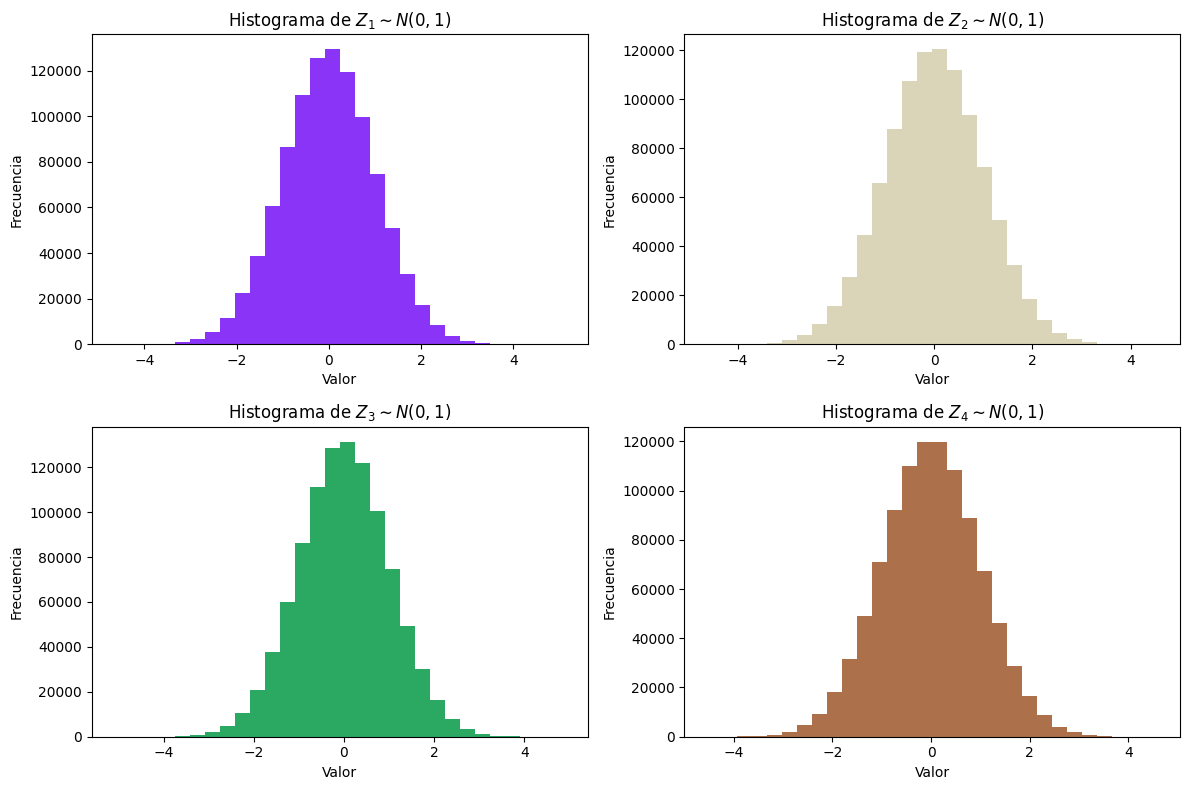

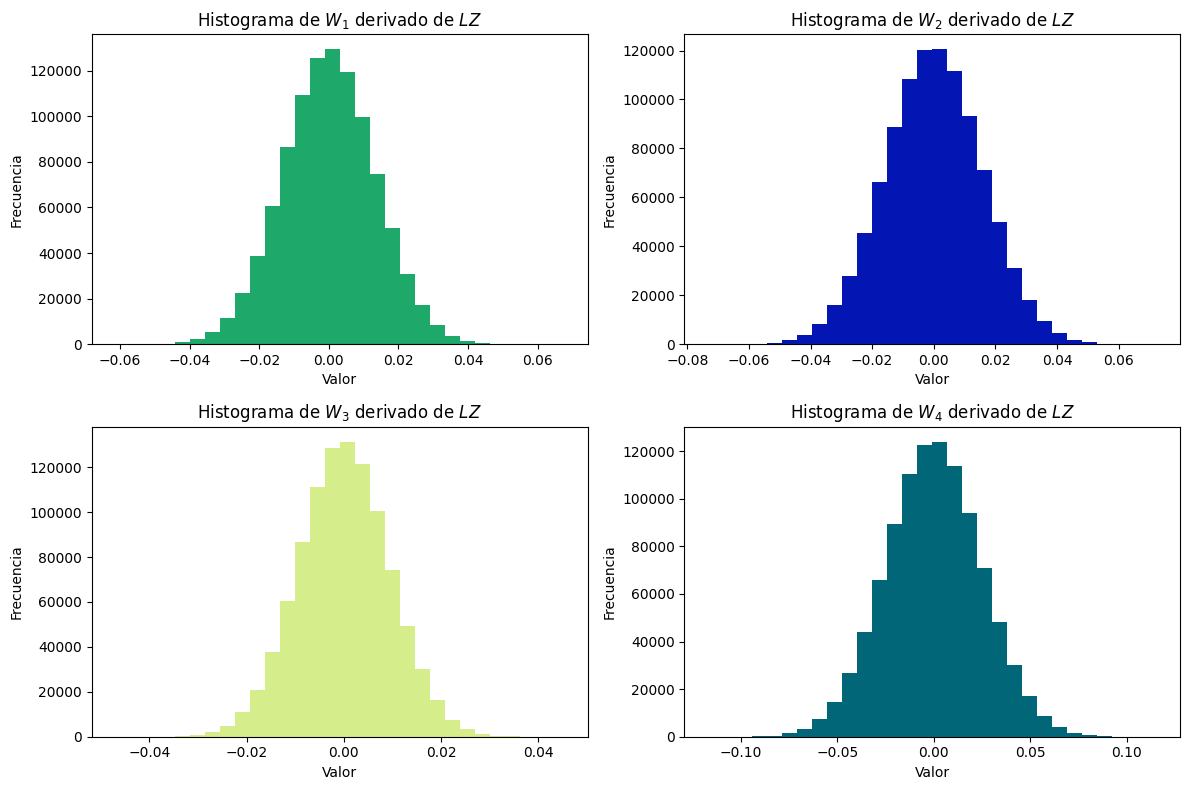

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import random

# genera 4 variables aleatorias Z1,...,Z4 iid ~  N(0,1)
n = 1000000 # cada una con 1000000 valores
Z = [np.random.randn(n) for _ in range(4)]

# la matriz Z_mat esta ya ordenado para la multiplicacion
Z_mat = np.column_stack(Z)    # matriz 1000 × 5

# genera X = L Z   (aplicando a cada fila)
# cada fila Z^(k) se transforma en X^(k)
X_mat = Z_mat @ L.T   # matriz 1000 × 4 vectorizado

# funcion color aleatorio
def color_random():
    return (random.random(), random.random(), random.random())

# histogramas de Z_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]
    
    ax.hist(Z_mat[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $Z_{{{i+1}}} \sim N(0,1)$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# histogramas de X_i en una sola ventana con 4 subplots (2 filas x 2 columnas)
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i in range(4):
    fila = i // 2     # 0 o 1
    col  = i % 2      # 0 o 1
    ax = axes[fila, col]

    ax.hist(X_mat[:, i], bins=30, color=color_random())
    ax.set_title(fr"Histograma de $W_{{{i+1}}}$ derivado de $LZ$")
    ax.set_xlabel("Valor")
    ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Generando el vector C a partir de un simplex empleando una distribucion de dirichlet

In [48]:
rng = np.random.default_rng(42)
d = 4          # dimensión del simplex
n_samples = 700

# cada fila de samples es un vector en el simplex (suma 1, no negativo)
c = rng.dirichlet(alpha=np.ones(d), size=n_samples)
print(c)

[[0.32467572 0.31549012 0.32204942 0.03778475]
 [0.01423223 0.23918586 0.23215518 0.51442673]
 [0.03469727 0.45795037 0.03082127 0.47653109]
 ...
 [0.24205269 0.15099577 0.19125074 0.41570081]
 [0.08752411 0.12238426 0.59430692 0.19578472]
 [0.10438282 0.59443086 0.15333361 0.14785271]]
